# Kaleb Tsegaye - Notebook 1: EDA and Modeling

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import humanize

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import ConfusionMatrixDisplay

np.random.seed(123)

### Reading in the data

In [10]:
data = pd.read_csv('data/Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_values.csv')
data_targets = pd.read_csv('data/Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_labels.csv')

In [11]:
data_targets.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [12]:
data = pd.merge(left=data, right=data_targets, on='id', how='left')

### EDA

In [13]:
data['date_recorded'].sort_values(ascending=False) # long range of values, but most in 2011-2013

2233     2013-12-03
30397    2013-12-03
36885    2013-12-03
45798    2013-12-03
30678    2013-12-03
            ...    
32619    2004-03-01
23373    2004-03-01
33942    2004-03-01
27501    2004-01-07
2601     2002-10-14
Name: date_recorded, Length: 59400, dtype: object

In [14]:
data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


#### Heatmap

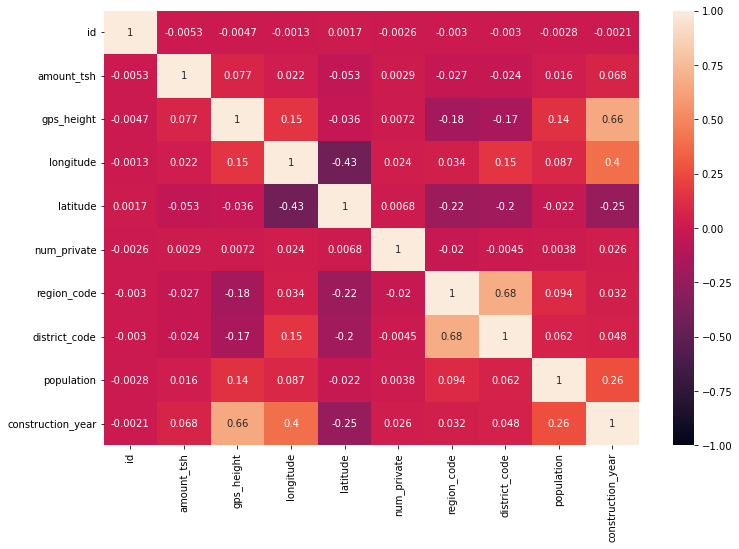

In [15]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), vmin=-1, annot=True);

#### Looking at columns that are practically duplicates

In [16]:
data[['waterpoint_type', 'waterpoint_type_group']].value_counts() # can remove one, they correspond 1-to-1

waterpoint_type              waterpoint_type_group
communal standpipe           communal standpipe       28522
hand pump                    hand pump                17488
other                        other                     6380
communal standpipe multiple  communal standpipe        6103
improved spring              improved spring            784
cattle trough                cattle trough              116
dam                          dam                          7
dtype: int64

In [17]:
data[['payment', 'payment_type']].value_counts() # can remove one, they correspond 1-to-1

payment                payment_type
never pay              never pay       25348
pay per bucket         per bucket       8985
pay monthly            monthly          8300
unknown                unknown          8157
pay when scheme fails  on failure       3914
pay annually           annually         3642
other                  other            1054
dtype: int64

In [18]:
data[['quantity', 'quantity_group']].value_counts() # can remove one, they correspond 1-to-1

quantity      quantity_group
enough        enough            33186
insufficient  insufficient      15129
dry           dry                6246
seasonal      seasonal           4050
unknown       unknown             789
dtype: int64

In [19]:
data['status_group'].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [20]:
data[['extraction_type', 'extraction_type_group', 'extraction_type_class']].value_counts() #  maybe remove extraction_type_group, possibily extraction_type_class, but not sure

extraction_type            extraction_type_group  extraction_type_class
gravity                    gravity                gravity                  26780
nira/tanira                nira/tanira            handpump                  8154
other                      other                  other                     6430
submersible                submersible            submersible               4764
swn 80                     swn 80                 handpump                  3670
mono                       mono                   motorpump                 2865
india mark ii              india mark ii          handpump                  2400
afridev                    afridev                handpump                  1770
ksb                        submersible            submersible               1415
other - rope pump          rope pump              rope pump                  451
other - swn 81             other handpump         handpump                   229
windmill                   wind-power

In [21]:
data[['management', 'management_group']].value_counts() # maybe remove management_group, since less granular data

management        management_group
vwc               user-group          40507
wug               user-group           6515
water board       user-group           2933
wua               user-group           2535
private operator  commercial           1971
parastatal        parastatal           1768
water authority   commercial            904
other             other                 844
company           commercial            685
unknown           unknown               561
other - school    other                  99
trust             commercial             78
dtype: int64

In [22]:
data[['water_quality', 'quality_group']].value_counts() # maybe just keep water_quality, remember soft==good lol

water_quality       quality_group
soft                good             50818
salty               salty             4856
unknown             unknown           1876
milky               milky              804
coloured            colored            490
salty abandoned     salty              339
fluoride            fluoride           200
fluoride abandoned  fluoride            17
dtype: int64

In [23]:
data[['source', 'source_type', 'source_class']].value_counts() # source is probably best, more granular

source                source_type           source_class
spring                spring                groundwater     17021
shallow well          shallow well          groundwater     16824
machine dbh           borehole              groundwater     11075
river                 river/lake            surface          9612
rainwater harvesting  rainwater harvesting  surface          2295
hand dtw              borehole              groundwater       874
lake                  river/lake            surface           765
dam                   dam                   surface           656
other                 other                 unknown           212
unknown               other                 unknown            66
dtype: int64

In [24]:
# removing duplicate columns
cols_to_remove = ['source_type', 'source_class', 'quality_group', 'management_group', 'extraction_type_group', 'extraction_type_class', 'quantity_group', 'payment_type', 'waterpoint_type_group']

#### Looking into more columns

In [25]:
# checking which columns have more than 10 unique values
for col in data.select_dtypes(object).columns:
    if data[col].value_counts().count() > 10:
        print(col, data[col].value_counts().count())

date_recorded 356
funder 1897
installer 2145
wpt_name 37400
subvillage 19287
region 21
lga 125
ward 2092
scheme_management 12
scheme_name 2696
extraction_type 18
extraction_type_group 13
management 12


In [26]:
data['date_recorded'].value_counts().count() # how many dates recorded

356

In [27]:
data.isnull().sum()[data.isnull().sum() > 0] # which columns have nas?

funder                3635
installer             3655
subvillage             371
public_meeting        3334
scheme_management     3877
scheme_name          28166
permit                3056
dtype: int64

In [28]:
# removing cols with a lot of nas
cols_to_remove = cols_to_remove + ['funder', 'installer', 'subvillage', 'public_meeting', 'scheme_management', 'scheme_name', 'permit', 'date_recorded']
cols_to_remove = cols_to_remove + ['wpt_name', 'ward', 'lga']


### Basic Model

In [29]:
# X, y, train test split
X = data.drop(labels=cols_to_remove + ['status_group'], axis=1)
y = data['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [30]:
# encoding object columns that remain in df
ct_ohe = make_column_transformer(
    (OneHotEncoder(sparse=False, drop='if_binary'), make_column_selector(dtype_include=object)),
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [31]:
# making pipe for model
pipe_logreg = make_pipeline(
    ct_ohe,
    StandardScaler(with_mean=False),
    LogisticRegression(max_iter=10000)
)

pipe_logreg.fit(X_train, y_train)

pipe_logreg.score(X_train, y_train), pipe_logreg.score(X_test, y_test)

(0.7345230078563412, 0.7307744107744107)

In [35]:
# Grid search cross validation, didnt improve score
params = {
    'logisticregression__C': [.01, .1, 1, 10, 100],
    'logisticregression__tol': [0.0001, 0.001, 0.01]
}
gs_logreg = GridSearchCV(pipe_logreg, param_grid=params, n_jobs=-1)
gs_logreg.fit(X_train, y_train)
gs_logreg.score(X_train, y_train), gs_logreg.score(X_test, y_test)

(0.734320987654321, 0.7306397306397306)

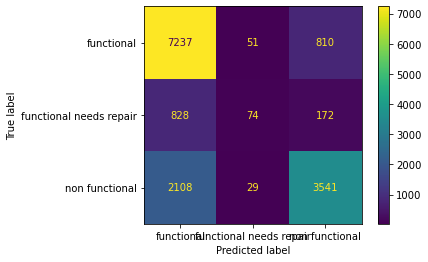

In [41]:
# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, pipe_logreg.predict(X_test));